# eQTL Processing

In [1]:
import glob
import os
import random
random.seed(20151226)
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_processing')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_processing')
cpy.makedir(private_outdir)

In [3]:
exp = pd.read_table(os.path.join(
        ciepy.root, 'output', 'eqtl_input', 
        'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), 
                    index_col=0)

## Results

In [4]:
# This calculates empirical p-values based on the p-values from permutations.
min_fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results', 
                                 '*', 'minimum_pvalues.tsv'))
min_fns = pd.Series(min_fns, index=[fn.split(os.path.sep)[-2] for fn in min_fns])
fn = os.path.join(outdir, 'pvalues.tsv')
if os.path.exists(fn):
    pvals = pd.read_table(fn, index_col=0,
                          header=None, squeeze=True)
else:
    pvals = pd.Series()
fn = os.path.join(outdir, 'most_sig.tsv')
if os.path.exists(fn):
    ms = pd.read_table(fn, index_col=0)
else:
    ms = pd.DataFrame()
new_pvals = []
new_genes = []
most_sig = []
most_sig_genes = []

min_fns = min_fns[set(min_fns.index) - set(pvals.index)]
for fn in min_fns.values:
    g = fn.split(os.path.sep)[-2]
    new_genes.append(g)
    res_fn = os.path.join(os.path.split(fn)[0], '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(res_fn)
    min_pvals = pd.read_table(fn, header=None, squeeze=True)
    p = (1 + sum(min_pvals <= res.PVALUE.min())) / float(min_pvals.shape[0] + 1)
    new_pvals.append(p)
    t = res[res.PVALUE == res.PVALUE.min()]
    most_sig_genes += [g] * t.shape[0]
    most_sig += list(t.values)
if len(min_fns) == 0:
    g = pvals.index[0]
    res_fn = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 
                          'results', g, '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(res_fn)
new_pvals = pd.Series(new_pvals, index=new_genes)
if new_pvals.shape[0] > 0:
    pvals = pd.concat([pvals, new_pvals])
pvals.to_csv(os.path.join(outdir, 'pvalues.tsv'), sep='\t')

if len(most_sig) > 0:    
    most_sig = pd.DataFrame(most_sig, index=most_sig_genes,
                            columns=res.columns)
    most_sig.columns = [x.lower() for x in most_sig.columns]
    most_sig['chrom'] = 'chr' + most_sig.chrom.astype(str)
    most_sig['coord'] = most_sig.beg
    most_sig['loc'] = most_sig.chrom + ':' + most_sig.coord.astype(str)
    most_sig['gene'] = most_sig.index
    most_sig = most_sig[['chrom', 'beg', 'end', 'loc', 'gene', 'marker_id', 'ns', 'ac', 
                         'callrate', 'genocnt', 'maf', 'stat', 'pvalue', 'beta',
                         'sebeta', 'r2']]
    most_sig.columns = ['chrom', 'start'] + list(most_sig.columns[2:])
    most_sig['start'] -= 1
    most_sig['ref'] = most_sig.marker_id.apply(lambda x: x.split('_')[1].split('/')[0])
    most_sig['alt'] = most_sig.marker_id.apply(lambda x: x.split('_')[1].split('/')[1])
    most_sig['length'] = most_sig.apply(lambda x: max(len(x['ref']), len(x['alt'])), axis=1)
    most_sig['length'] = (most_sig.ref.apply(lambda x: len(x)) - most_sig.alt.apply(lambda x: len(x))).abs()
    most_sig['vtype'] = 'snp'
    most_sig.ix[most_sig.ref.apply(lambda x: len(x)) > most_sig.alt.apply(lambda x: len(x)), 'vtype'] = 'del'
    most_sig.ix[most_sig.ref.apply(lambda x: len(x)) < most_sig.alt.apply(lambda x: len(x)), 'vtype'] = 'ins'
    most_sig = pd.concat([ms, most_sig])
else:
    most_sig = ms
most_sig.to_csv(os.path.join(outdir, 'most_sig.tsv'), sep='\t')

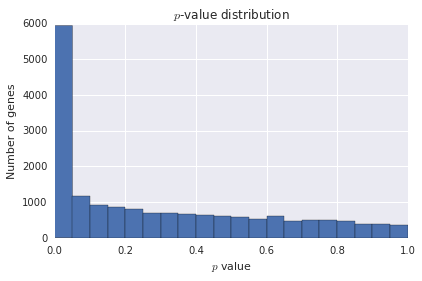

In [5]:
pvals.hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('$p$-value distribution')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'p_value_hist.pdf'))

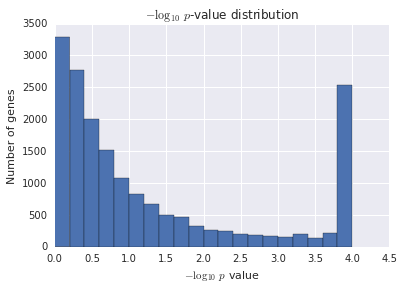

In [6]:
(-np.log10(pvals)).hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$-\log_{10}$ $p$ value')
plt.title('$-\log_{10}$ $p$-value distribution');

## FDR Correction

In [7]:
%%R

library(qvalue)

From the qvalue manual:
    
*The argument stat must be such that the larger the value is the more deviated (i.e., "more extreme")
from the null hypothesis it is. Examples include an F-statistic or the absolute value of a t-statistic.
The argument stat0 should be calculated analogously on data that represents observations from
the null hypothesis distribution. The p-values are calculated as the proportion of values from stat0
that are greater than or equal to that from stat. If pool=TRUE is selected, then all of stat0 is used
in calculating the p-value for a given entry of stat. If pool=FALSE, then it is assumed that stat0
is a matrix, where stat0[i,] is used to calculate the p-value for stat[i]. The function empPvals
calculates "pooled" p-values faster than using a for-loop.*

I think I should be able to use the $-\log_{10}$ $p$-values is a statistic to derive empirical
$p$-values that I can then use with qvalue.

In [8]:
%%R -i pvals -o qvalues,pi0,lfdr,sig

qobj = qvalue(p=pvals, fdr.level=0.05)
#qobj = qvalue(p=pvals)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr
sig <- qobj$significant

summary(qobj)


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.4053552	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value     2537   3256  4294   5099  5941 7102 17765
q-value        0   2975  3969   4685  5563 7066 17769
local FDR      0   2537  3136   3421  3706 4247 17769



`pi0` is the estimated proportion of true null hypotheses.

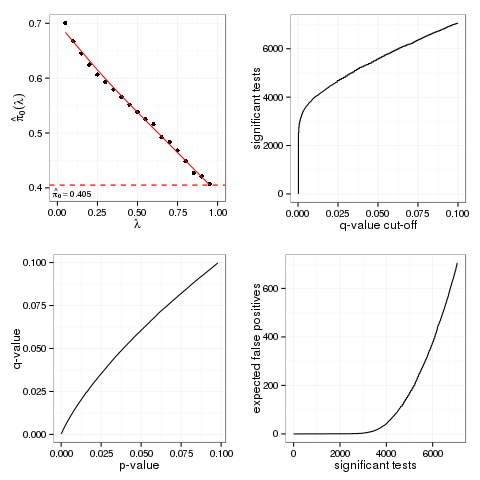

In [9]:
%%R

plot(qobj)

In [10]:
qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                          index=['pvalue', 'qvalue', 'sig'],
                          columns=pvals.index).T
qvalue_res['sig'] = qvalue_res.sig.astype(bool)
qvalue_res = qvalue_res.sort_values(['qvalue'])
qvalues = pd.Series(list(qvalues), index=pvals.index)
qvalue_res.index.name = 'gene_id'
qvalue_res.to_csv(os.path.join(outdir, 'qvalues.tsv'), sep='\t')

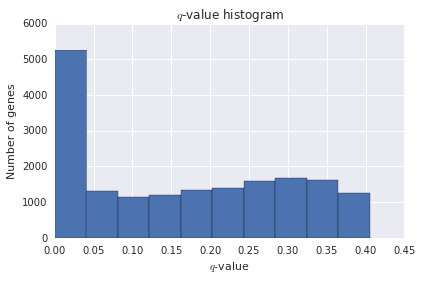

In [11]:
qvalues.hist()
plt.title('$q$-value histogram')
plt.ylabel('Number of genes')
plt.xlabel('$q$-value')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'q_value_hist.pdf'))

## Most Significant Variant per Gene

It can be useful to define the most significant variant per gene
for various analyses. I've already done that except sometimes there
are ties. I'll choose just one variant per gene here so that I can 
use a consistent set of most significant variants in other analyses.

In [12]:
fn = os.path.join(outdir, 'most_sig_single.tsv')
if not os.path.exists(fn):
    t = qvalue_res.copy(deep=True)
    t.columns = ['{}_gene'.format(x) for x in t.columns]
    most_sig_single = most_sig.join(t)
    # To choose randomly, I'll assign a random number to each row, then sort
    # by gene and row.
    random.seed(204050)
    most_sig_single['random'] = [random.random() for x in most_sig_single.index]
    most_sig_single = most_sig_single.sort_values(by=['gene', 'random'])
    most_sig_single = most_sig_single.drop_duplicates(subset=['gene'])
    most_sig_single = most_sig_single.drop(['gene', 'random'], axis=1)
    most_sig_single.to_csv(fn, sep='\t')
else:
    most_sig_single = pd.read_table(fn, index_col=0)

I also want to get the most significant SNV per gene since some analyses
won't work with indels. I'll replace indels with a random most-significant
SNV.

In [ ]:
fn = os.path.join(outdir, 'most_sig_single_snv.tsv')
if not os.path.exists(fn):
    indel_genes = most_sig_single[(most_sig_single.end - most_sig_single.start) > 1].index
    new_rows = []
    dy = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 'results')
    for g in indel_genes:
        fn = os.path.join(dy, g, '{}.tsv'.format(g))
        df = ciepy.read_emmax_output(fn)
        df = df[df.END - df.BEG == 0]
        df = df[df.PVALUE == df.PVALUE.min()]
        new_rows.append(df.ix[random.choice(df.index)])
    tdf = pd.DataFrame(new_rows)
    tdf.index = indel_genes
    tdf.columns = [x.lower() for x in tdf.columns]

    tdf['chrom'] = 'chr' + tdf.chrom.astype(str)
    tdf['coord'] = tdf.beg
    tdf['loc'] = tdf.chrom + ':' + tdf.coord.astype(str)
    tdf['gene'] = tdf.index
    tdf = tdf[['chrom', 'beg', 'end', 'loc', 'gene', 'marker_id', 'ns', 'ac', 
                         'callrate', 'genocnt', 'maf', 'stat', 'pvalue', 'beta',
                         'sebeta', 'r2']]
    tdf.columns = ['chrom', 'start'] + list(tdf.columns[2:])
    tdf['start'] -= 1
    tdf['ref'] = tdf.marker_id.apply(lambda x: x.split('_')[1].split('/')[0])
    tdf['alt'] = tdf.marker_id.apply(lambda x: x.split('_')[1].split('/')[1])
    tdf['length'] = tdf.apply(lambda x: max(len(x['ref']), len(x['alt'])), axis=1)
    tdf['length'] = (tdf.ref.apply(lambda x: len(x)) - tdf.alt.apply(lambda x: len(x))).abs()
    tdf['vtype'] = 'snp'
    tdf = tdf.drop('gene', axis=1)

    t = qvalue_res.copy(deep=True)
    t.columns = ['{}_gene'.format(x) for x in t.columns]
    tdf = tdf.join(t)
    most_sig_single_snv = most_sig_single.drop(indel_genes)
    most_sig_single_snv = pd.concat([most_sig_single_snv, tdf])
    most_sig_single_snv.to_csv(fn, sep='\t')
else:
    most_sig_single_snv = pd.read_table(fn, index_col=0)

### Null variants

I'm going to LD prune the most-significant SNVs and make null sets of SNVs.

## Significant Variant-Gene Pairs

I'll identitify significant variant-gene pairs the same way that GTEx does. Basically,
I need to find what permutation $p$-value maps to a $q$-value of 0.05. Then for each 
gene. I find out what nominal $p$-value maps to that permutation $p$-value. All variants
with $p$ less than this nominal $p$-value are considered significant.

I'll use an IPython cluster to speed up the calculation of the permutation $p$-values.
This code took several hours to run with 13 engines.

In [ ]:
def calc_perm_pval(p, min_pvals):
    perm_p = (1 + sum(min_pvals <= p)) / float(min_pvals.shape[0] + 1)
    return [p, perm_p]

out_fn = os.path.join(outdir, 'gene_variant_pairs.tsv')
if not os.path.exists():
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    # Get permutation p-value cutoff that maps to q = 0.05.
    diff = qvalue_res.qvalue - 0.05
    perm_pval = qvalue_res.ix[diff == diff.abs().min(), 'pvalue'][0]

    dview.push(dict(calc_perm_pval=calc_perm_pval))
    gene_variant_pairs = []

    for g in qvalue_res[qvalue_res.sig].index:
        fn = min_fns[g]
        res_fn = os.path.join(os.path.split(fn)[0], '{}.tsv'.format(g))
        res = ciepy.read_emmax_output(res_fn).dropna(subset=['PVALUE'])
        min_pvals = pd.read_table(fn, header=None, squeeze=True)
        dview.push(dict(min_pvals=min_pvals))
        t = dview.map_sync(lambda x: calc_perm_pval(x, min_pvals), set(res.PVALUE))
        t = pd.Series(dict(zip([x[0] for x in t], [x[1] for x in t])))
        res['perm_pval'] = t[res.PVALUE].values
        tdf = res[res.perm_pval <= perm_pval]
        tdf['gene'] = g
        gene_variant_pairs.append(tdf)
        
    gene_variant_pairs = pd.concat(gene_variant_pairs)
    gene_variant_pairs.index = range(gene_variant_pairs.shape[0])
    gene_variant_pairs.columns = [x.lower() for x in gene_variant_pairs.columns]
    gene_variant_pairs['chrom'] = 'chr' + gene_variant_pairs['chrom'].astype(str)
    gene_variant_pairs.to_csv(out_fn, sep='\t', index=None)
else:
    gene_variant_pairs = pd.read_table(out_fn)

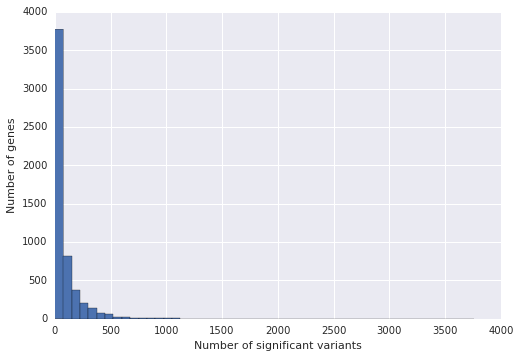

In [140]:
vc = gene_variant_pairs.gene.value_counts()
vc.hist(bins=50)
plt.ylabel('Number of genes')
plt.xlabel('Number of significant variants');

## Combined Results

I want to make a file with all EMMAX results combined. I am going to 
sort this file by position and $p$-value. This will allow me to 
collect some stats like the smallest $p$-value observed for each SNV,
how many times a SNV was tested, etc.

I'll use the IPython cluster to sort the individual output files then
merge them using `sort -m`. This is much faster than concatenating and
sorting though the merging still takes a few hours.

In [ ]:
out = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    dy = os.path.join(outdir, 'tmp')
    cpy.makedir(dy)
    fns = glob.glob(os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 
                                 'results', 'ENS*', 'ENS*.tsv'))
    commands = ['sort -k1,1 -k2,2n -k3,3n -k11,11n {} | grep -v ^# | '
                'awk \'{{print $0"\t{}"}}\' > {}'.format(x, x.split('/')[-2], os.path.join(dy, os.path.split(x)[1]))
                for x in fns]
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    with dview.sync_imports():
        import subprocess
    dview.scatter('commands', commands)
    %px y = [subprocess.check_call(i, shell=True) for i in commands]
    c = 'sort -m -k1,1 -k2,2n -k3,3n -k11,11n {} | bgzip -c > {}'.format(os.path.join(dy, '*'), out)
    subprocess.check_call(c, shell=True)
    c = 'tabix -p bed {}'.format(out)
    subprocess.check_call(c, shell=True)
    c = 'rm -r {}'.format(dy)
    subprocess.check_call(c, shell=True)

Cluster has 13 engines.
importing subprocess on engine(s)


In [193]:
out = os.path.join(outdir, 'top_snv_results_sorted.tsv.gz')
if not os.path.exists(out):
    i = os.path.join(outdir, 'all_snv_results_sorted.tsv.gz')
    c = ("zcat {} | awk 'a!~$1 || b!~$2 || c!~$3 ; {{a=$1}} {{b=$2}} {{c=$3}}' | "
         "bgzip -c > {}".format(i, out))
    subprocess.check_call(c, shell=True)
    c = 'tabix -p bed {}'.format(out)
    subprocess.check_call(c, shell=True)

In [ ]:
3 +

## Pseudoheritability

These pseudoheratibility estimates may not be that accurate because I've 
regressed out the PEER factors which could remove broad genetic effects
on expression. I probably want to re-run EMMAX without the PEER factors 
to estimate heritability.

In [ ]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing',
                  'pseudoheritability.tsv')
if os.path.exists(fn):
    ph = pd.read_table(fn, index_col=0)
    todo = set(pvals.index) - set(ph.index)
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])
else:
    todo = list(ph.index)
    ph = pd.DataFrame(columns=['observed', 'mean_permuted', 'median_permuted'])
    new_ph = pd.DataFrame(
        -1, index=todo,
        columns=['observed', 'mean_permuted', 'median_permuted'])

for i in new_ph.index:
    new_ph.ix[i, 'observed'] = float(open(os.path.join(
            ciepy.root, 'output', 'run_eqtl_analysis', 'results', i, 
            '{}.reml'.format(i))).read().split('\n')[5].split()[1])
    fn = os.path.join(ciepy.root, 'output', 'run_eqtl_analysis', 
                      'results', i, 'permuted_reml.tsv')
    df = pd.read_table(fn, low_memory=False)
    new_ph.ix[i, 'mean_permuted'] = df.h2.mean()
    new_ph.ix[i, 'median_permuted'] = df.h2.median()
ph = pd.concat([ph, new_ph])
ph.to_csv(fn, sep='\t')